## Task 2: Develop Time Series Forecasting Models

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
tsla = pd.read_csv('../data/TSLA_cleaned.csv', index_col='Date', parse_dates=True)

# Ensure 'Adj Close' is available and drop NaNs if needed
tsla['Adj Close'] = pd.to_numeric(tsla['Adj Close'], errors='coerce')
tsla = tsla.dropna(subset=['Adj Close'])

# Split the data (e.g., 80% training, 20% testing)
train_size = int(len(tsla) * 0.8)
train, test = tsla['Adj Close'][:train_size], tsla['Adj Close'][train_size:]


In [7]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-02 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2474 non-null   float64
 1   High       2474 non-null   float64
 2   Low        2474 non-null   float64
 3   Close      2474 non-null   float64
 4   Volume     2474 non-null   float64
 5   Adj Close  2474 non-null   float64
dtypes: float64(6)
memory usage: 135.3 KB


In [8]:
tsla.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-01-02 00:00:00+00:00,14.858000,14.883333,14.217333,14.620667,71466000.0,14.620667
2015-01-05 00:00:00+00:00,14.303333,14.433333,13.810667,14.006000,80527500.0,14.006000
2015-01-06 00:00:00+00:00,14.004000,14.280000,13.614000,14.085333,93928500.0,14.085333
2015-01-07 00:00:00+00:00,14.223333,14.318667,13.985333,14.063333,44526000.0,14.063333
2015-01-08 00:00:00+00:00,14.187333,14.253333,14.000667,14.041333,51637500.0,14.041333


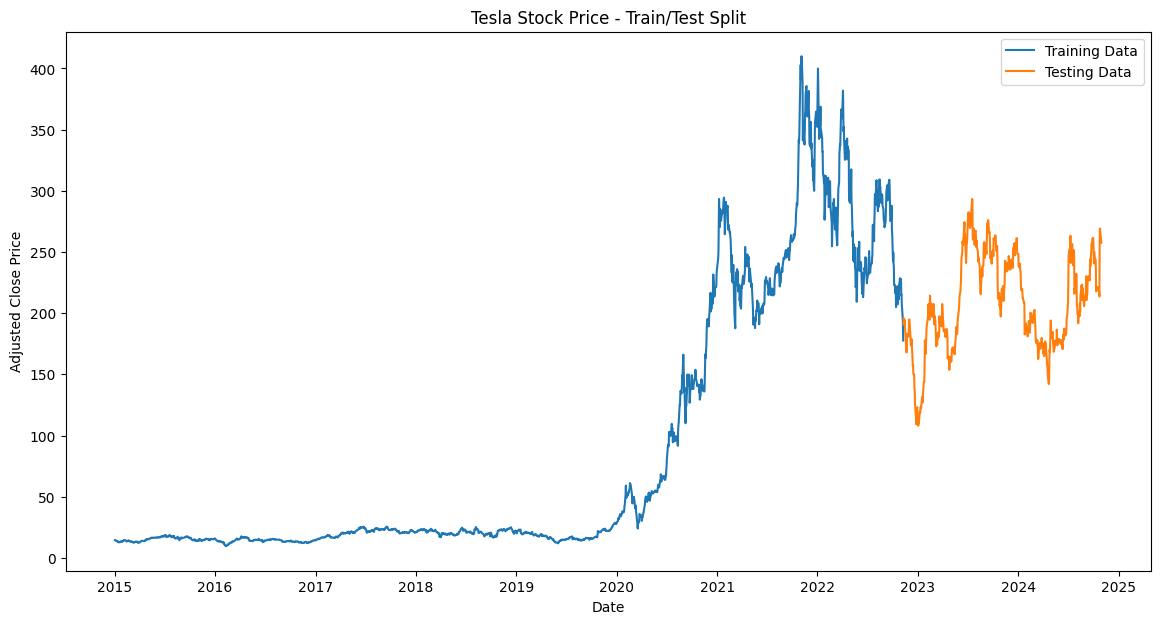

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.title('Tesla Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [33]:
from pmdarima import auto_arima

# Use auto_arima to search for a more complex model
model_auto_arima = auto_arima(train, seasonal=False, max_p=3, max_q=3, d=1, trace=True, stepwise=True)
print(model_auto_arima.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12681.898, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12706.274, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12704.830, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12704.866, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12704.722, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12707.657, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12708.790, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12675.418, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12707.829, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12677.347, Time=2.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12675.340, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12707.453, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=12673.837, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=12705.963, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0

### Assign a Frequency to the Date Index

In [11]:
# Ensure the date index has a frequency
train = train.asfreq('B')  # 'B' stands for business days
test = test.asfreq('B')

# Check if the frequency is set
print(train.index.freq)


<BusinessDay>


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Extract the best parameters from auto_arima
p, d, q = model_auto_arima.order

# Fit the ARIMA model
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2049
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6173.705
Date:                Mon, 11 Nov 2024   AIC                          12349.410
Time:                        18:46:03   BIC                          12355.034
Sample:                    01-02-2015   HQIC                         12351.472
                         - 11-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.3696      0.313     93.685      0.000      28.755      29.984
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):             23036.98
Prob(Q):                              0.06   Pr

### Model Validation

#### Residual Analysis: Check if the residuals are white noise by plotting them and analyzing their autocorrelation function (ACF).

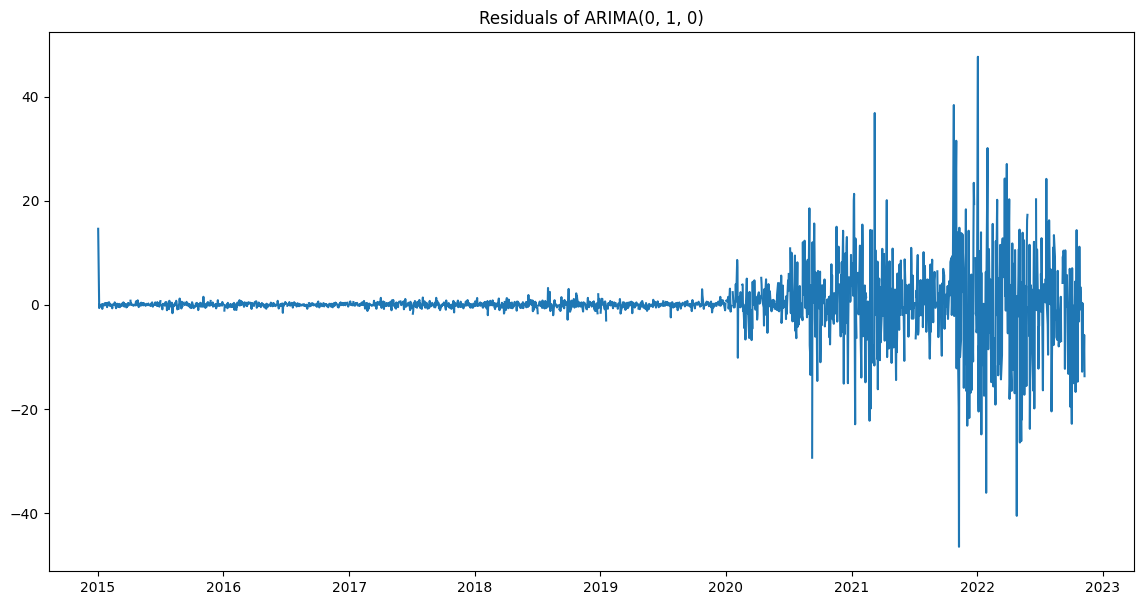

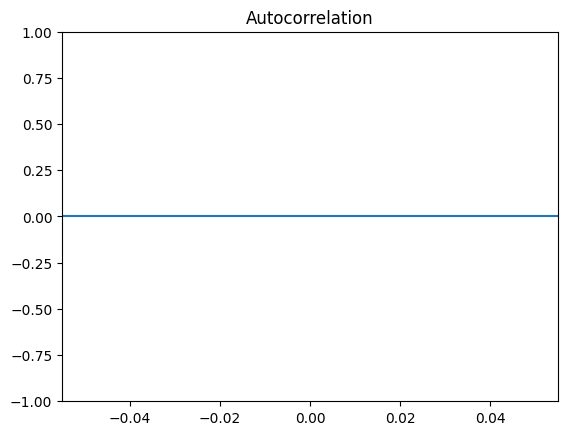

In [35]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Plot residuals
residuals = arima_model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals of ARIMA(0, 1, 0)')
plt.show()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


In [ ]:
import statsmodels.api as sm
residuals = arima_model_fit.resid

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


#### Forecast Future Prices: Use the model to forecast future prices and compare with actual test data.

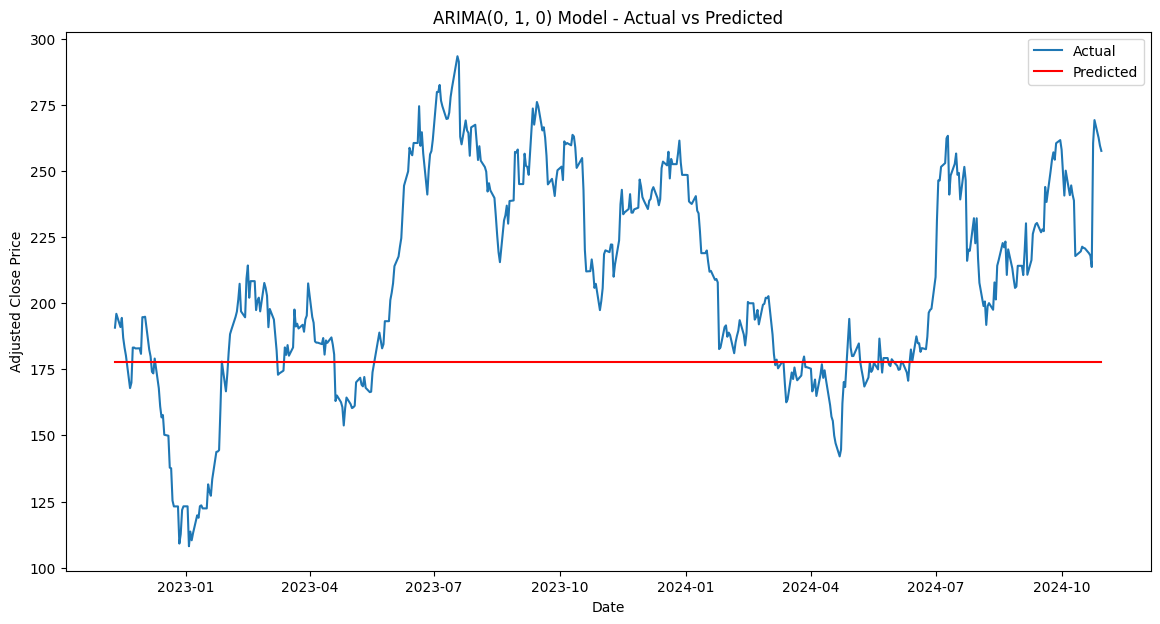

In [39]:
# Forecast future values
forecast_steps = len(test)  # Number of steps to forecast (size of test set)
predictions = arima_model_fit.forecast(steps=forecast_steps)

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('ARIMA(0, 1, 0) Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [15]:
# Fill NaN values using forward fill or zero
test_clean = test.ffill()  # Use 'bfill()' or fillna(0) if preferred

# Ensure predictions align with filled 'test'
predictions_clean = predictions[test_clean.index]



In [16]:
import numpy as np
# Ensure the indices of test_clean and predictions_clean match
aligned_index = test_clean.index.intersection(predictions_clean.index)
test_clean = test_clean.loc[aligned_index]
predictions_clean = predictions_clean[aligned_index]

# Double-check for NaN values
print(f"Number of NaN values in aligned 'test': {test_clean.isnull().sum()}")
print(f"Number of NaN values in aligned 'predictions': {np.isnan(predictions_clean).sum()}")


Number of NaN values in aligned 'test': 0
Number of NaN values in aligned 'predictions': 0


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_clean, predictions_clean)
rmse = np.sqrt(mean_squared_error(test_clean, predictions_clean))
mape = np.mean(np.abs((test_clean - predictions_clean) / test_clean)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 39.06
Root Mean Squared Error (RMSE): 49.23
Mean Absolute Percentage Error (MAPE): 17.75%


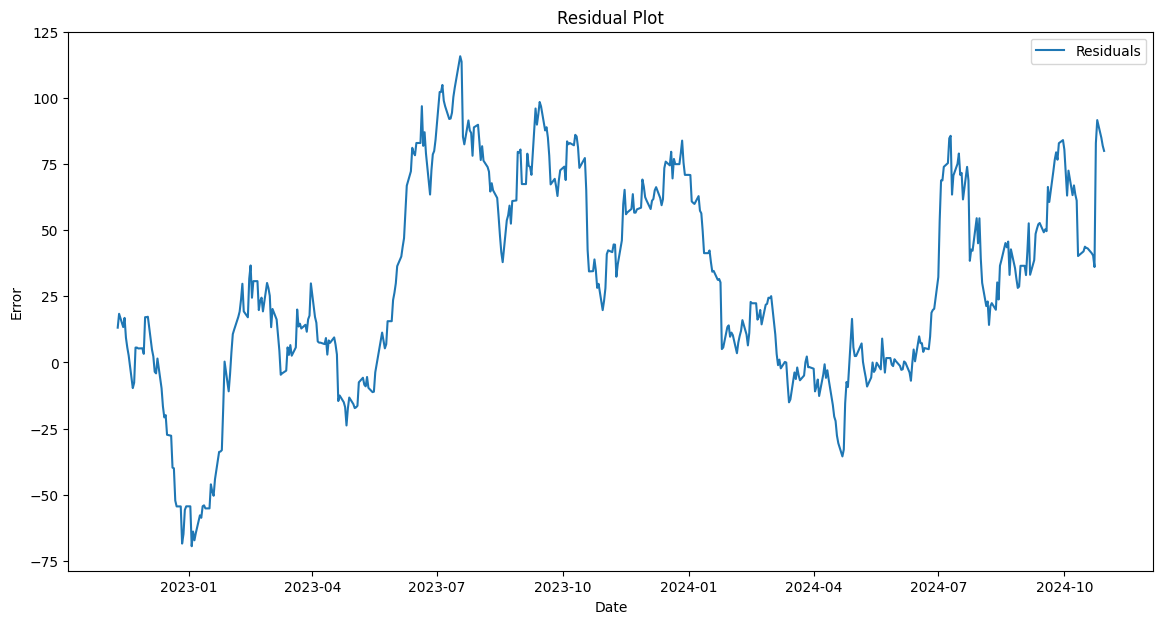

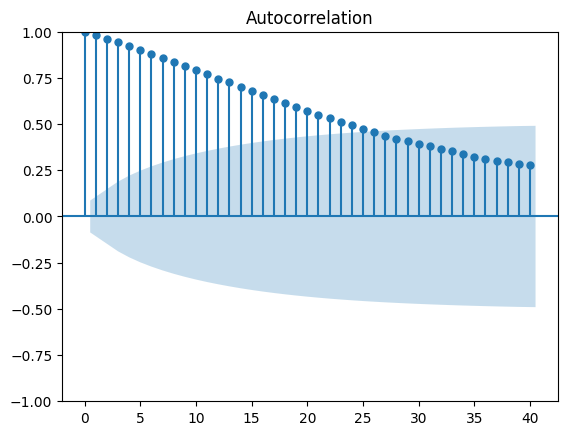

In [13]:
import matplotlib.pyplot as plt

residuals = test_clean - predictions_clean
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals')
plt.title('Residual Plot')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot ACF of residuals to check for patterns
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


### SARIMA Model


In [18]:
train = train.ffill()

In [19]:
from pmdarima import auto_arima

# Find best SARIMA parameters
model_auto_sarima = auto_arima(train, seasonal=True, m=30, trace=True, stepwise=True)
print(model_auto_sarima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=12685.878, Time=13.20 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=12706.274, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=12706.662, Time=1.25 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=12706.695, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=12704.722, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=12683.898, Time=23.50 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=12681.898, Time=4.25 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=12683.897, Time=22.47 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=12707.657, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=12708.790, Time=0.75 sec
 ARIMA(3,1,2)(0,0,0)[30] intercept   : AIC=12675.418, Time=3.14 sec
 ARIMA(3,1,2)(1,0,0)[30] intercept   : AIC=12677.418, Time=24.07 sec
 ARIMA(3,1,2)(0,0,1)[30] intercept   : AIC=12677.418, Time=24.21 sec
 ARIMA(3,1,2)(1,0,1)[30] intercept   : AIC=12679.412, Time=25.35 sec

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model using the best parameters
sarima_model = SARIMAX(train, order=model_auto_sarima.order, seasonal_order=model_auto_sarima.seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2049
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -6330.919
Date:                Mon, 11 Nov 2024   AIC                          12673.837
Time:                        18:51:44   BIC                          12707.585
Sample:                    01-02-2015   HQIC                         12686.214
                         - 11-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3925      0.015    -91.492      0.000      -1.422      -1.363
ar.L2         -0.8683      0.016    -55.579      0.000      -0.899      -0.838
ma.L1          1.3657      0.018     76.218      0.0

### LSTM Model

In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale data between 0 and 1
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Create LSTM input sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


c:\Users\zelalem.wubet\projects\personal\ten-academy\Portfolio-Optimization-TimeSeries\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0166
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.1656e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 7.9371e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.5541e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.2572e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.7663e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.9790e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.2515e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.5046e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.6165e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.1552e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.6254e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.4625e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.5793e-04
Epoch 15/50
63/63 ━

In [28]:
test = test.ffill() 

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, RMSE, MAPE
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 39.06
Root Mean Squared Error (RMSE): 49.23
Mean Absolute Percentage Error (MAPE): 17.75%


## Task 3: Forecast Future Market Trends

### Forecast Future Values: Use the fitted ARIMA(2, 1, 3)

Forecasted Prices:
2022-11-10 00:00:00+00:00    177.589996
2022-11-11 00:00:00+00:00    177.589996
2022-11-14 00:00:00+00:00    177.589996
2022-11-15 00:00:00+00:00    177.589996
2022-11-16 00:00:00+00:00    177.589996
                                ...    
2023-10-23 00:00:00+00:00    177.589996
2023-10-24 00:00:00+00:00    177.589996
2023-10-25 00:00:00+00:00    177.589996
2023-10-26 00:00:00+00:00    177.589996
2023-10-27 00:00:00+00:00    177.589996
Freq: B, Name: predicted_mean, Length: 252, dtype: float64
2022-11-10: $177.59
2022-11-11: $177.59
2022-11-14: $177.59
2022-11-15: $177.59
2022-11-16: $177.59
2022-11-17: $177.59
2022-11-18: $177.59
2022-11-21: $177.59
2022-11-22: $177.59
2022-11-23: $177.59
2022-11-24: $177.59
2022-11-25: $177.59
2022-11-28: $177.59
2022-11-29: $177.59
2022-11-30: $177.59
2022-12-01: $177.59
2022-12-02: $177.59
2022-12-05: $177.59
2022-12-06: $177.59
2022-12-07: $177.59
2022-12-08: $177.59
2022-12-09: $177.59
2022-12-12: $177.59
2022-12-13: $177.59
20

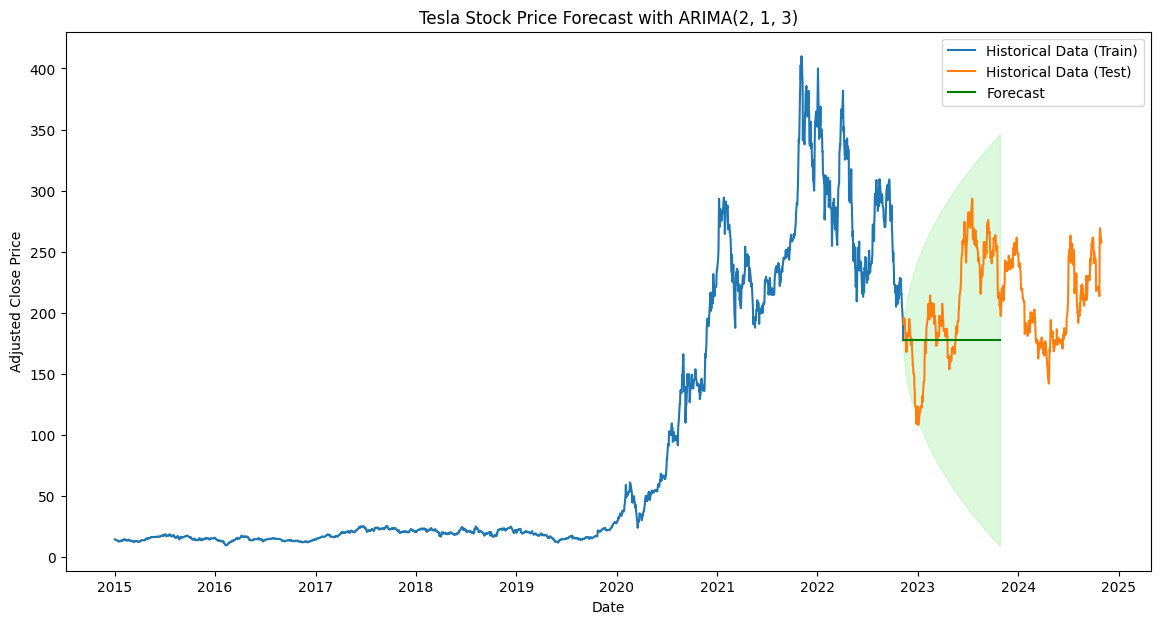

In [37]:
# Forecast for the next 6-12 months (e.g., 252 trading days)
forecast_steps = 252
forecast = arima_model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print forecasted prices
print("Forecasted Prices:")
print(forecast_mean)

# Optionally print with dates and formatted output
for date, price in forecast_mean.items():
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

# Plot historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Historical Data (Train)')
plt.plot(test.index, test, label='Historical Data (Test)')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')

# Plot confidence intervals
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)

plt.title('Tesla Stock Price Forecast with ARIMA(2, 1, 3)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()



#### Plot LSTM Forecasted Prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

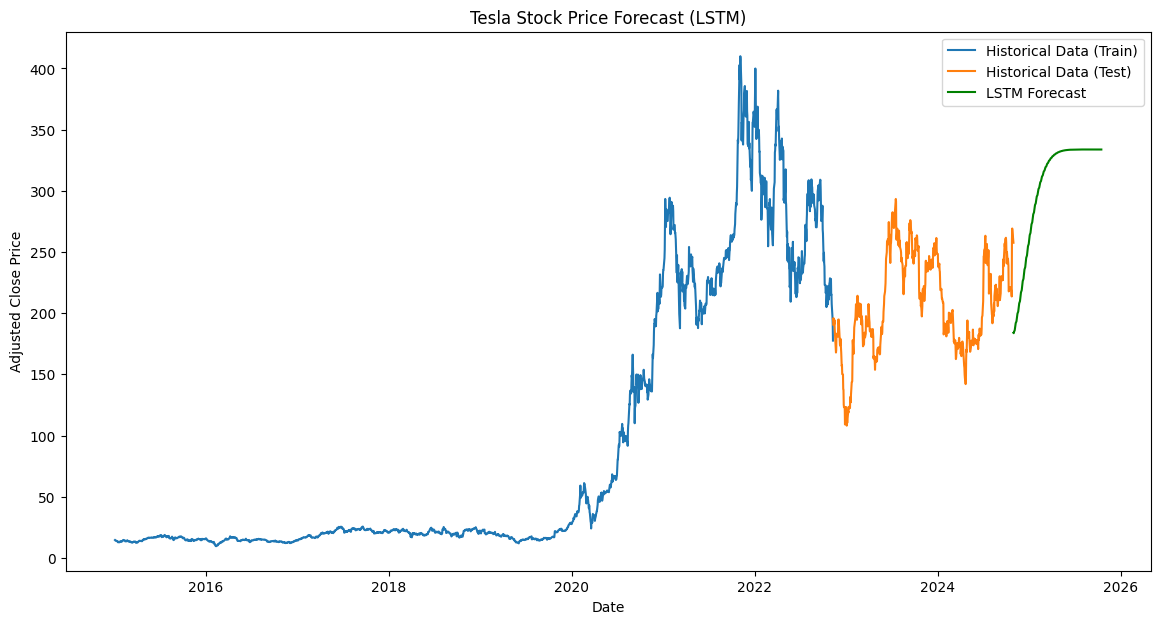

In [38]:
import pandas as pd

# Predict next steps using LSTM
last_sequence = train_scaled[-sequence_length:]  # Last input sequence for the LSTM
predictions = []

for _ in range(forecast_steps):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the predictions to get actual price values
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a date range for the forecasted values
forecast_dates = pd.date_range(test.index[-1], periods=forecast_steps, freq='B')

# Print forecasted prices with dates
print("LSTM Forecasted Prices:")
for date, price in zip(forecast_dates, predictions_rescaled):
    print(f"{date.strftime('%Y-%m-%d')}: ${price[0]:.2f}")

# Plot predictions with historical data
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Historical Data (Train)')
plt.plot(test.index, test, label='Historical Data (Test)')
plt.plot(forecast_dates, predictions_rescaled, label='LSTM Forecast', color='green')
plt.title('Tesla Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()
